# Predictor y productor de música con IA

##Maxime Vilcocq Parra, A01710550
##Módulo 2 Implementación de un modelo de deep learning. (Portafolio Implementación)

#Entrenamiento

In [ ]:
!apt-get install -y fluidsynth
!pip install -q music21 pretty_midi midi2audio tensorflow keras matplotlib scikit-learn


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
import os
import json
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

#Los warnings pueden deberse a que tensorflow ya viene con colab

In [ ]:

BASE_DIR = Path("/content/melody_project")
DATA_DIR = BASE_DIR / "data"
MODELS_DIR = BASE_DIR / "models"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print("Carpetas listas:")
print("Data:", DATA_DIR)
print("Models:", MODELS_DIR)


!ls -R /content/melody_project

Carpetas listas:
Data: /content/melody_project/data
Models: /content/melody_project/models
/content/melody_project:
data  models

/content/melody_project/data:
clasico_notas.npy	      combinado_secuencias_datos.npz
clasico_notas_unicas.json     videojuegos_notas.npy
clasico_secuencias_datos.npz  videojuegos_notas_unicas.json
combinado_notas.npy	      videojuegos_secuencias_datos.npz
combinado_notas_unicas.json

/content/melody_project/models:


#Cargar manualmente archivos

En el colab previo (https://colab.research.google.com/drive/16VD0yEaqxWeHzIyjWVACfSvbXD3cR01i?usp=sharing) creamos nueve archivos con terminación:

notas.npy

secuencias_datos.npz

notas_unicas.json

Hay que descargar estos archivos y cargarlos en la carpeta data dentro de la carpeta melody_project

##Cargar las secuencias para entrenar

In [ ]:
def load_sequence_data(data_path, prefix):
    with open(data_path / f"{prefix}_notas_unicas.json", "r") as f:
        unique_notes = json.load(f)
    data = np.load(data_path / f"{prefix}_secuencias_datos.npz")
    inputs, targets = data["inputs"], data["targets"]

    n_vocab = len(unique_notes)
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1)) / float(n_vocab)
    targets = to_categorical(targets, num_classes=n_vocab)
    return inputs, targets, n_vocab

##Construir modelo con LSTM

Usamos este mismo modelo para entrenar tres modelos distintos, uno con música clásica, otro con música de videojuegos y otro con la combinación de ambos

In [ ]:
from tensorflow.keras.optimizers import Adam
def build_lstm_model(n_vocab, seq_length=50):
    model = Sequential([
        LSTM(256, input_shape=(seq_length, 1), return_sequences=True),
        Dropout(0.3),
        LSTM(256),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_vocab, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

##Esta función entrena al modelo

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

def train_dataset(prefix, epochs=50):
    print(f"\n--- Entrenando modelo completo: {prefix.upper()} ---")

    # Cargar datos y vocabulario
    with open(DATA_DIR / f"{prefix}_notas_unicas.json", "r") as f:
        unique_notes = json.load(f)
    data = np.load(DATA_DIR / f"{prefix}_secuencias_datos.npz")
    inputs, targets = data["inputs"], data["targets"]

    # Normalización y codificación
    n_vocab = len(unique_notes)
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1)) / float(n_vocab)
    targets = to_categorical(targets, num_classes=n_vocab)

    print(f"Entradas: {inputs.shape}, Salidas: {targets.shape}, Vocabulario: {n_vocab}")

    # Construcción del modelo
    model = build_lstm_model(n_vocab)
    checkpoint_path = MODELS_DIR / f"model_{prefix}.keras"

    # Guardar mejor modelo según pérdida
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', verbose=1, save_best_only=True)

    # Entrenamiento sin separación
    history = model.fit(inputs, targets, epochs=epochs, batch_size=64, callbacks=[checkpoint], verbose=1)

    print(f"Modelo {prefix} guardado en:", checkpoint_path)
    return model, history


##Entrenamiento de música clásica




Correr cualquiera de las 3 celdas siguientes reinicia el modelo, más adelante se permite continuar el entrenamiento con el modelo generado a partir de los modelos generados.

In [ ]:
model_clasico, history_c = train_dataset("clasico", epochs=50)


--- Entrenando modelo completo: CLASICO ---
Entradas: (1143, 50, 1), Salidas: (1143, 46), Vocabulario: 46


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.0651 - loss: 3.6692
Epoch 1: loss improved from inf to 3.53630, saving model to /content/melody_project/models/model_clasico.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 522ms/step - accuracy: 0.0659 - loss: 3.6622
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.0962 - loss: 3.3205
Epoch 2: loss improved from 3.53630 to 3.36671, saving model to /content/melody_project/models/model_clasico.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 447ms/step - accuracy: 0.0954 - loss: 3.3230
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.1018 - loss: 3.3074
Epoch 3: loss improved from 3.36671 to 3.34194, saving model to /content/melody_project/models/model_clasico.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 517ms/step - accuracy: 0.1014 - loss: 3.3092
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.0922 - loss: 3.3264
Epoch 4: loss improved from 3.34194 to 3.32062, saving model to /content/melody_project/m

##Entrenamiento con música de videojuegos

model_videojuegos, history_v = train_dataset("videojuegos", epochs=50


No permite la convergencia con el modelo normal, dejo captura para ahorrarnos la ejecución

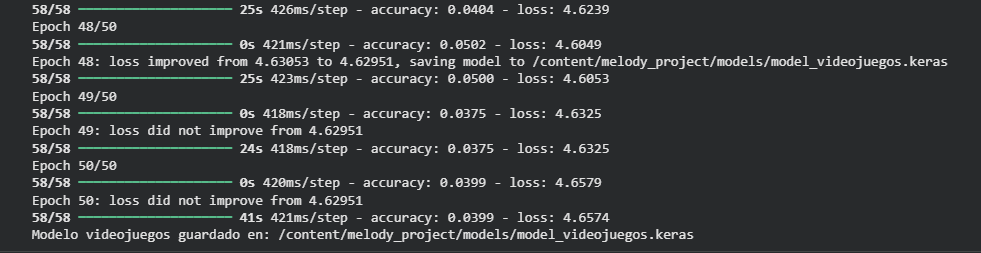

In [ ]:
#model_videojuegos, history_v = train_dataset("videojuegos", epochs=50)

##Modelo combinado (clásico y videojuegos)

model_combinado, history_comb = train_dataset("combinado", epochs=50)
Tampoco permite la convergencia con el modelo normal

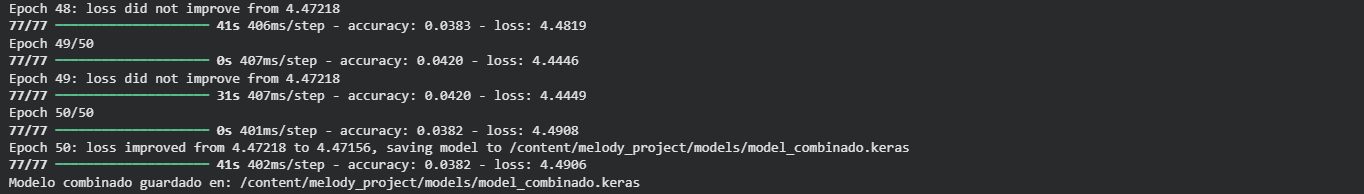

In [ ]:
#model_combinado, history_comb = train_dataset("combinado", epochs=50)

##Graficar rendimiento de los modelos

In [ ]:
def plot_history(history, title="Historial de entrenamiento"):
    epochs = range(1, len(history.history['loss']) + 1)
    fig, ax1 = plt.subplots(figsize=(6,4))

    ax1.plot(epochs, history.history['loss'], 'b-', label='Entrenamiento (Loss)')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(epochs, history.history['accuracy'], 'orange', label='Entrenamiento (Accuracy)')
    ax2.set_ylabel('Accuracy', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='lower right')

    plt.title(title)
    plt.show()

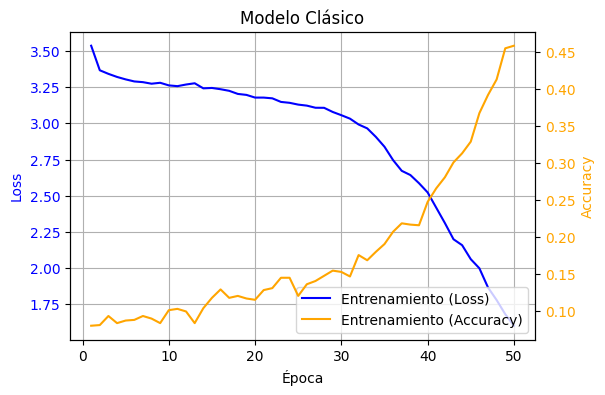

In [ ]:
plot_history(history_c, "Modelo Clásico")


In [ ]:
#plot_history(history_v, "Modelo Videojuegos")

plot_history(history_v, "Modelo Videojuegos")

Se puede ver como se estanca

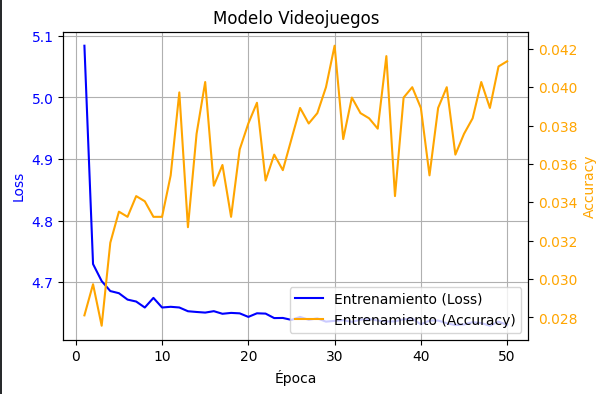

In [ ]:
#plot_history(history_comb, "Modelo Combinado")

plot_history(history_comb, "Modelo Combinado")

Se puede observar muy bien cómo se estanca

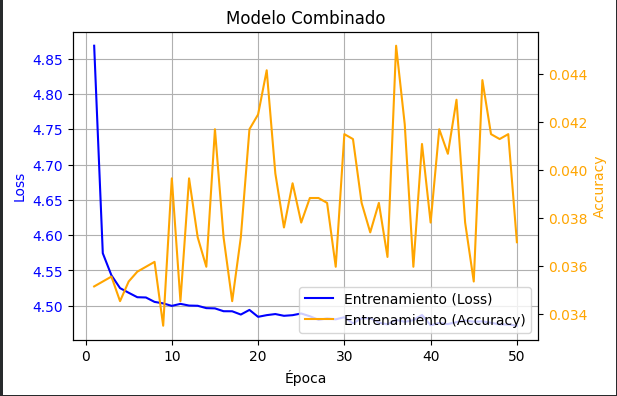

##Como vemos falla bastante con los videojuegos por la variabilidad
Para solucionar esto uso embedings y también una limpieza de notas

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau

def build_lstm_model_embed(n_vocab, seq_length=50):
    model = Sequential([
        Embedding(input_dim=n_vocab, output_dim=128, input_length=seq_length),
        LSTM(256, return_sequences=True),
        Dropout(0.3),
        LSTM(256),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_vocab, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

def train_dataset_embed(prefix, epochs=50):
    print(f"\n--- Entrenando modelo con Embedding: {prefix.upper()} ---")

    with open(DATA_DIR / f"{prefix}_notas_unicas.json", "r") as f:
        unique_notes = json.load(f)
    data = np.load(DATA_DIR / f"{prefix}_secuencias_datos.npz")
    inputs, targets = data["inputs"], data["targets"]

    n_vocab = len(unique_notes)
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1]))
    targets = to_categorical(targets, num_classes=n_vocab)

    print(f"Entradas: {inputs.shape}, Salidas: {targets.shape}, Vocabulario: {n_vocab}")

    model = build_lstm_model_embed(n_vocab)
    checkpoint_path = MODELS_DIR / f"model_{prefix}_embed.keras"

    checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='loss', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

    history = model.fit(inputs, targets,
                        epochs=epochs,
                        batch_size=64,
                        validation_split=0.1,
                        callbacks=[checkpoint, reduce_lr],
                        verbose=1)

    print(f"Modelo {prefix} (con embeddings) guardado en:", checkpoint_path)
    return model, history


In [ ]:
model_videojuegos_embed, history_v_embed = train_dataset_embed("videojuegos", epochs=25)


--- Entrenando modelo con Embedding: VIDEOJUEGOS ---
Entradas: (3700, 50), Salidas: (3700, 354), Vocabulario: 354
Epoch 1/25


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.0271 - loss: 5.4693
Epoch 1: loss improved from inf to 5.20764, saving model to /content/melody_project/models/model_videojuegos_embed.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 43s 573ms/step - accuracy: 0.0272 - loss: 5.4645 - val_accuracy: 0.1081 - val_loss: 4.0384 - learning_rate: 0.0010
Epoch 2/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.0279 - loss: 4.8346
Epoch 2: loss improved from 5.20764 to 4.83819, saving model to /content/melody_project/models/model_videojuegos_embed.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 579ms/step - accuracy: 0.0279 - loss: 4.8347 - val_accuracy: 0.0081 - val_loss: 3.9787 - learning_rate: 0.0010
Epoch 3/25
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.0241 - loss: 4.7765
Epoch 3: loss improved from 4.83819 to 4.74421, saving model to /content/melody_project/models/model_videojuegos_embed.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 564ms/step - accuracy: 0.0242 - loss: 4.7759 - val_accuracy: 0.1081

In [ ]:
plot_history(history_v_embed, "Modelo Videojuegos")

In [ ]:
model_combinado_embed, history_comb_embed = train_dataset_embed("combinado", epochs=25)


--- Entrenando modelo con Embedding: COMBINADO ---
Entradas: (4893, 50), Salidas: (4893, 357), Vocabulario: 357
Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.0312 - loss: 5.2866
Epoch 1: loss improved from inf to 4.95869, saving model to /content/melody_project/models/model_combinado_embed.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 46s 593ms/step - accuracy: 0.0312 - loss: 5.2819 - val_accuracy: 0.0122 - val_loss: 4.2017 - learning_rate: 0.0010
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.0449 - loss: 4.5814
Epoch 2: loss improved from 4.95869 to 4.53958, saving model to /content/melody_project/models/model_combinado_embed.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 585ms/step - accuracy: 0.0449 - loss: 4.5808 - val_accuracy: 0.0122 - val_loss: 4.1059 - learning_rate: 0.0010
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.0409 - loss: 4.3980
Epoch 3: loss improved from 4.53958 to 4.37296, saving model to /content/melody_project/models/model_co

In [ ]:
plot_history(history_comb_embed, "Modelo Combinado")

##Mejorar los modelos con epocas adicionales

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def continue_training(prefix, extra_epochs=40):
    print(f"\n--- Reanudando entrenamiento del modelo: {prefix.upper()} ---")

    # Cargar el modelo previamente guardado
    model_path = MODELS_DIR / f"model_{prefix}.keras"
    model = load_model(model_path)
    print(f"Modelo cargado desde: {model_path}")

    # Cargar todo el dataset completo (sin splits)
    with open(DATA_DIR / f"{prefix}_notas_unicas.json", "r") as f:
        unique_notes = json.load(f)
    data = np.load(DATA_DIR / f"{prefix}_secuencias_datos.npz")
    inputs, targets = data["inputs"], data["targets"]

    n_vocab = len(unique_notes)

    # Normalización y codificación
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1)) / float(n_vocab)
    targets = to_categorical(targets, num_classes=n_vocab)

    print(f"Entradas: {inputs.shape}, Salidas: {targets.shape}, Vocabulario: {n_vocab}")

    # Callbacks
    checkpoint = ModelCheckpoint(
        filepath=MODELS_DIR / f"model_{prefix}.keras",
        monitor='loss',
        verbose=1,
        save_best_only=True
    )

    #No se usa, pero se ouede introducir en el callback para parar antes
    earlystop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    # Entrenamiento adicional sobre todo el dataset
    history = model.fit(
        inputs, targets,
        epochs=extra_epochs,
        batch_size=64,
        callbacks=[checkpoint],
        verbose=1
    )

    print(f"Entrenamiento extendido completado. Modelo actualizado en: {model_path}")

    return history


In [ ]:
history_c = continue_training("clasico", extra_epochs=40)


--- Reanudando entrenamiento del modelo: CLASICO ---
Modelo cargado desde: /content/melody_project/models/model_clasico.keras
Entradas: (1143, 50, 1), Salidas: (1143, 46), Vocabulario: 46
Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4875 - loss: 1.6086
Epoch 1: loss improved from inf to 1.58706, saving model to /content/melody_project/models/model_clasico.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 451ms/step - accuracy: 0.4875 - loss: 1.6074
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.5371 - loss: 1.4375
Epoch 2: loss improved from 1.58706 to 1.48014, saving model to /content/melody_project/models/model_clasico.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 519ms/step - accuracy: 0.5354 - loss: 1.4398
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5830 - loss: 1.2962
Epoch 3: loss improved from 1.48014 to 1.35962, saving model to /content/melody_project/models/model_clasico.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 521ms/step - accuracy: 0.5818 -

##Continuar entrenando los modelos con embeddings

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def continue_training_embed(prefix, extra_epochs=40):
    print(f"\n--- Reanudando entrenamiento (Embedding) del modelo: {prefix.upper()} ---")

    # Ruta del modelo base con embedding
    model_path = MODELS_DIR / f"model_{prefix}_embed.keras"
    model = load_model(model_path)
    print(f"Modelo con embeddings cargado desde: {model_path}")

    # Cargar dataset completo
    with open(DATA_DIR / f"{prefix}_notas_unicas.json", "r") as f:
        unique_notes = json.load(f)
    data = np.load(DATA_DIR / f"{prefix}_secuencias_datos.npz")
    inputs, targets = data["inputs"], data["targets"]

    n_vocab = len(unique_notes)
    # En modelos con Embedding NO se normaliza ni se agrega dimensión extra
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1]))
    targets = to_categorical(targets, num_classes=n_vocab)

    print(f"Entradas: {inputs.shape}, Salidas: {targets.shape}, Vocabulario: {n_vocab}")

    # Callbacks
    checkpoint = ModelCheckpoint(
        filepath=MODELS_DIR / f"model_{prefix}_embed.keras",
        monitor='loss',
        verbose=1,
        save_best_only=True
    )
    earlystop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

    # Entrenamiento extendido
    history = model.fit(
        inputs, targets,
        epochs=extra_epochs,
        batch_size=64,
        validation_split=0.1,
        callbacks=[checkpoint, reduce_lr],
        verbose=1
    )
    print(f"Entrenamiento extendido completado. Modelo actualizado en: {model_path}")

    return history


In [ ]:
history_v_embed = continue_training_embed("videojuegos", extra_epochs=5)


--- Reanudando entrenamiento (Embedding) del modelo: VIDEOJUEGOS ---
Modelo con embeddings cargado desde: /content/melody_project/models/model_videojuegos_embed.keras
Entradas: (3700, 50), Salidas: (3700, 354), Vocabulario: 354
Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9281 - loss: 0.2536
Epoch 1: loss improved from inf to 0.25702, saving model to /content/melody_project/models/model_videojuegos_embed.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 603ms/step - accuracy: 0.9281 - loss: 0.2537 - val_accuracy: 0.9784 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.9253 - loss: 0.2433
Epoch 2: loss improved from 0.25702 to 0.24411, saving model to /content/melody_project/models/model_videojuegos_embed.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 571ms/step - accuracy: 0.9253 - loss: 0.2433 - val_accuracy: 0.9865 - val_loss: 0.1323 - learning_rate: 0.0010
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.9381 -

In [ ]:
history_comb_embed = continue_training_embed("combinado", extra_epochs=5)


--- Reanudando entrenamiento (Embedding) del modelo: COMBINADO ---
Modelo con embeddings cargado desde: /content/melody_project/models/model_combinado_embed.keras
Entradas: (4893, 50), Salidas: (4893, 357), Vocabulario: 357
Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.9344 - loss: 0.2288
Epoch 1: loss improved from inf to 0.24549, saving model to /content/melody_project/models/model_combinado_embed.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 45s 592ms/step - accuracy: 0.9343 - loss: 0.2291 - val_accuracy: 0.5388 - val_loss: 4.3703 - learning_rate: 0.0010
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9223 - loss: 0.2624
Epoch 2: loss did not improve from 0.24549
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 574ms/step - accuracy: 0.9222 - loss: 0.2624 - val_accuracy: 0.5531 - val_loss: 4.2753 - learning_rate: 0.0010
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - accuracy: 0.9451 - loss: 0.1984
Epoch 3: loss improved from 0.24549 to 0.21645, saving model to /content/m

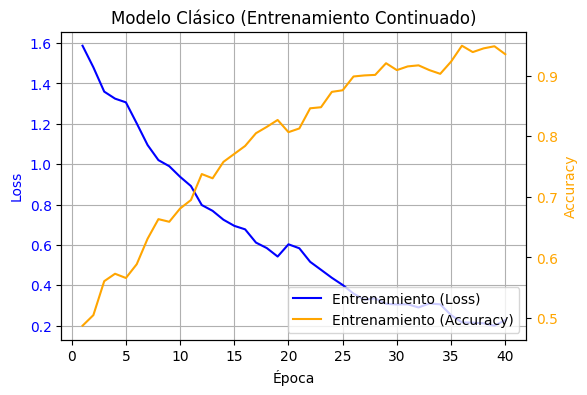

In [ ]:
plot_history(history_c, "Modelo Clásico (Entrenamiento Continuado)")

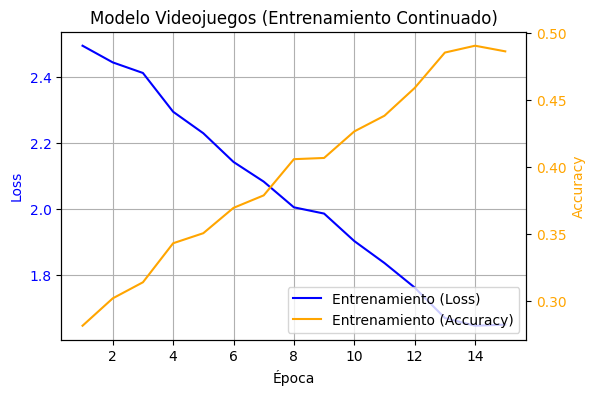

In [ ]:
plot_history(history_v_embed, "Modelo Videojuegos (Entrenamiento Continuado)")

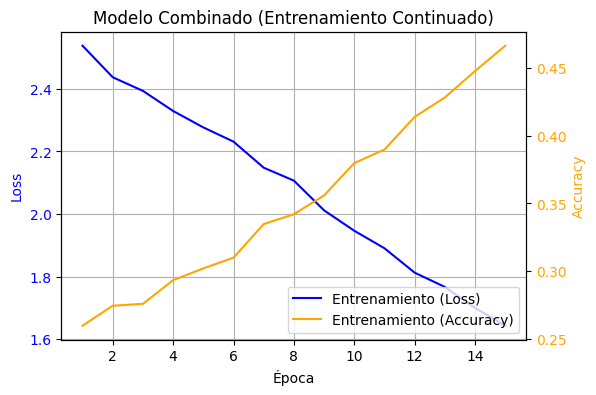

In [ ]:
plot_history(history_comb_embed, "Modelo Combinado (Entrenamiento Continuado)")

In [ ]:
!ls -R /content/melody_project/models

/content/melody_project/models:
model_clasico.keras  model_combinado_embed.keras  model_videojuegos_embed.keras


##Guardar los modelos

Los modelos se guardan en la carpeta de models, descarga los tres archivos generados para usar en el siguiente documento.

##Justificación del split (o falta de)

Dado el contexto del modelo, separar el modelo en train, test, split sería perjudicial para realmente aprender. El objetivo del modelo es predecir la nota que sigue en una secuencia preexistente sino y permitir la creación de nuevas canciones con un estilo determinado.

No nos interesa tanto el poder predecir una nota en un dataset nuevo, sino crear una melodía armoniosa.

En otros problemas el overfitting sería malo, pero este tiene la particularidad de que precisamente es lo que queremos conseguir para poder replicar canciones con un estilo similar.